In [1]:
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 952.9 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
!pip install scikeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.2 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, accuracy_score, classification_report, r2_score as r2
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
import torch
import keras
from keras.constraints import max_norm as MaxNorm
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from sklearn.pipeline import make_pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import random
random.seed(42)

In [99]:
#Importing Data
df = pd.read_csv('address_data_combined.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']

scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train_full.shape)
X_train_full.head()

(9908, 12)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
6709,17.06,0.00,51.17,1,101.0000,101.000000,101.000000,10.804780,33.666149,4,101.000000,0.001554
13808,2679.43,2841.02,275214.32,21,0.0001,15.000000,2.295850,0.000000,1.877316,100,103.313259,0.060902
8333,103299.49,37551.75,826452.87,6,0.0000,52.532971,23.290155,0.000000,16.627500,15,163.031084,30.011085
6981,4756.98,11283.84,46352.60,1,11.0000,20.000000,15.500000,9.975152,10.194942,7,31.000000,-19.974711
676,0.00,0.00,0.00,0,0.0000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000


In [6]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']

scaler = MinMaxScaler()

# Log for Skewed Data
# log on both train and test data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
# only use training data to fit, to avoid data leakage
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [7]:
#Optimal Parameters for each model from hyperparameter tuning
tabnet_params = {'gamma': 1.0,
                 'lambda_sparse': 0,
                 'momentum': 0.4,
                 'n_steps': 8,
                 'optimizer_params': {'lr': 0.025},
                 'verbose': 0}

xgb_params = {'learning_rate': 0.05,
              'max_depth': 8,
              'n_estimators': 1000}


mlp_params = {'input_dim': X_train_full.shape[1],
              'H': 60,
              'activation': 'relu',
              'dropout_probability': 0.2,
              'num_epochs': 75,
              'num_layers': 10}

svm_params = {'C': 1000,
              'gamma': 1}

rf_params = {'max_depth': 20,
               'min_samples_leaf': 5,
               'n_jobs': -1}




def compile_mlp(input_dim, H, num_epochs, num_layers, activation, dropout_probability):
    # Creating Sequential MLP
    model_n = Sequential()
    model_n.add(layers.Dense(H, input_shape=(input_dim, ), activation= activation))

    for _ in range(num_layers - 1):
        model_n.add(layers.Dense(H, activation= activation, kernel_constraint=MaxNorm(3)))
        model_n.add(layers.Dropout(dropout_probability))

    model_n.add(layers.Dense(1, activation='sigmoid'))
    # configure the model
    model_n.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True)])
    return model_n

In [8]:
# get a list of models to evaluate
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB
def get_models():
    models = dict()
    mlp = KerasClassifier(model = compile_mlp, **mlp_params)
    tabnet = TabNetClassifier(**tabnet_params)
    models['tabnet'] = tabnet
    models['svm'] = svm.SVC(**svm_params)
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = mlp
    models['randomforest'] = RandomForestClassifier(**rf_params)
    models['naivebayes']= GaussianNB(var_smoothing=2e-9)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)#, error_score='raise')
    return scores

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


>tabnet 0.901 (0.007)
>svm 0.916 (0.008)
>xgboost 0.926 (0.005)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>mlp 0.828 (0.038)
>randomforest 0.912 (0.004)
>naivebayes 0.766 (0.011)


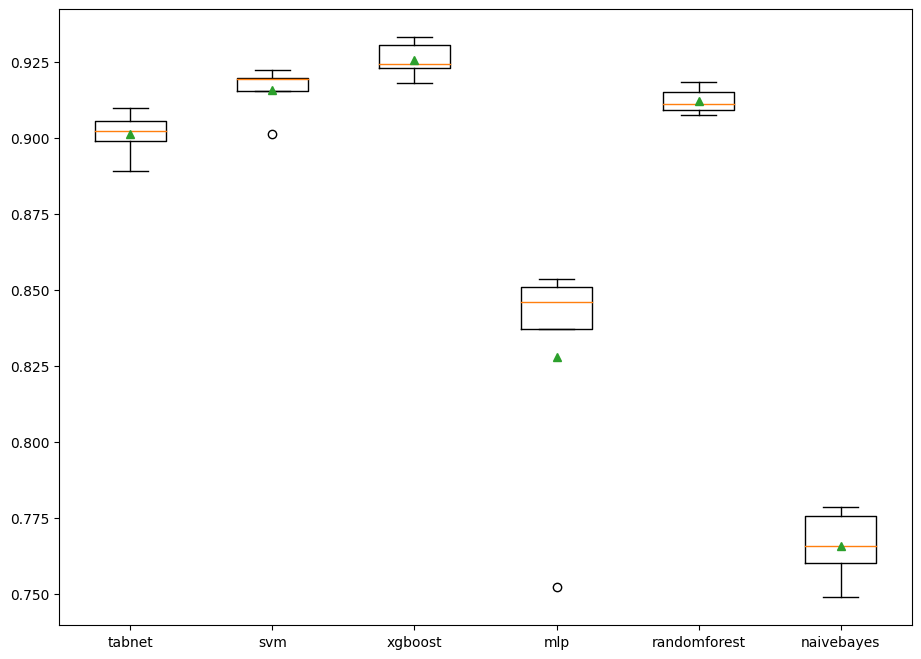

In [9]:
# define dataset
X, y = X_train_full, y_train_full
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [13]:
import warnings
warnings.filterwarnings("ignore")
import time
from sklearn.inspection import permutation_importance

#Creating Stacking model - Initialized using logistic regression model
def get_stacking():
    # define the base models
    level0 = list()
    for key,value in get_models().items():
        try:
            value._estimator_type = 'classifier'
        except AttributeError:
            pass
        finally:
            level0.append([key,value])
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv= 5, n_jobs = -1)
    return model

#Pipeline to get all models
def get_models2():
    models = dict()
    models['tabnet'] = TabNetClassifier(**tabnet_params)
    models['svm'] = svm.SVC(**svm_params)
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = KerasClassifier(model = compile_mlp, **mlp_params)
    models['randomforest'] = RandomForestClassifier(**rf_params)
    models['naivebayes']=GaussianNB(var_smoothing=2e-9)
    models['stacking'] = get_stacking()
    return models
result=[]
feature_names=[]
#Getting predictions from all models to evaluate performance on test set
predictions, names2, timing_list = list(), list(), list()
for name, model in get_models2().items():
    current_time = time.time()
    model.fit(X, y)
    if name == "stacking":
      result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    predictions.append(model.predict(X_test))
    names2.append(name)
    final_time = time.time()
    timing_list.append(final_time - current_time)
feature_importances = result.importances_mean

310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc_2: 0.6876 - loss: 0.6133
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━

In [157]:
y_pred=predictions[-1]
modelname=names2[-1]

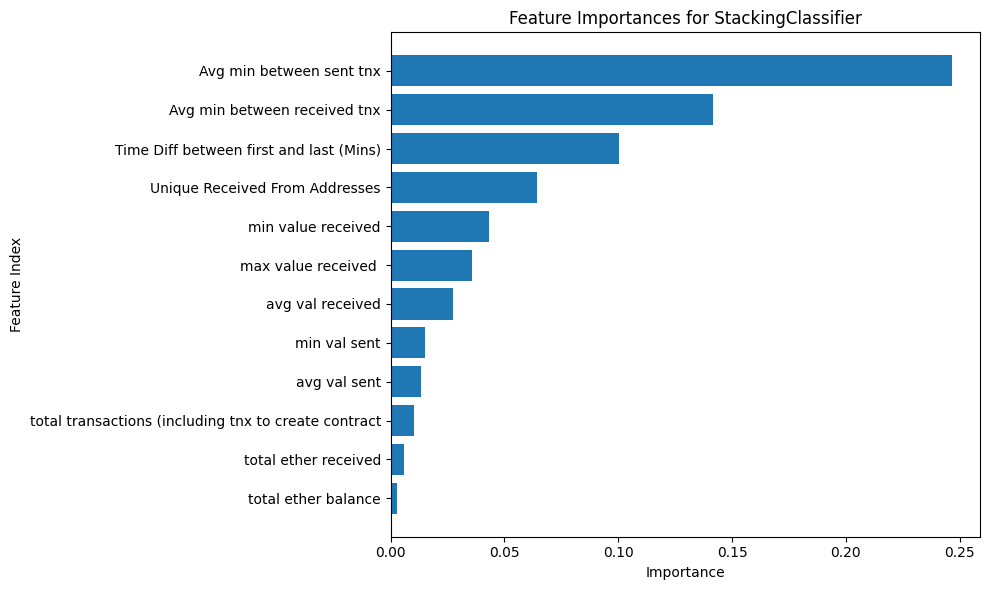

In [147]:
feats = {}
for feature, importance in zip(columns, feature_importances):
    feats[feature] = importance

importances_df = pd.DataFrame.from_dict(feats, orient='index', columns=['Importance'])

sorted_importances_df = importances_df.sort_values(by='Importance', ascending=False)

sorted_feature_names = sorted_importances_df.index.tolist()

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature Index")
plt.title("Feature Importances for StackingClassifier")
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.tight_layout()
plt.show()

In [150]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
results_df = pd.DataFrame()
results_df['Model'] = names2
results_df['Time taken'] = timing_list
results_df['Optimal Parameters'] = [tabnet_params,
                                    svm_params,
                                    xgb_params,
                                    mlp_params,
                                    rf_params,
                                    None,
                                    None]
metrics_dict = {'Accuracy': accuracy_score,
                'Precision': precision_score,
                'Recall': recall_score,
                'F1': f1_score,
                'ROC-AUC': roc_auc_score}
for metric, func in metrics_dict.items():
    storage = []
    for prediction in predictions:
        storage.append(func(y_test, prediction))
    results_df[metric] = storage

results_df.sort_values(['Accuracy', 'ROC-AUC'], ascending = [False, False])

,Model,Time taken,Optimal Parameters,Accuracy,Precision,Recall,F1,ROC-AUC
2,xgboost,3.265555,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.939958,0.930633,0.939673,0.935131,0.939937
6,stacking,819.792585,None,0.936190,0.923580,0.939162,0.931305,0.936407
1,svm,11.881921,"{'C': 1000, 'gamma': 1}",0.928891,0.912675,0.935072,0.923737,0.929343
4,randomforest,1.631767,"{'max_depth': 20, 'min_samples_leaf': 5, 'n_jo...",0.926301,0.914271,0.926892,0.920538,0.926344
0,tabnet,102.212607,"{'gamma': 1.0, 'lambda_sparse': 0, 'momentum':...",0.911467,0.923365,0.880879,0.901622,0.909231
3,mlp,7.583707,"{'input_dim': 12, 'H': 60, 'activation': 'relu...",0.868849,0.861499,0.852249,0.856849,0.867635
5,naivebayes,0.005606,None,0.773252,0.725784,0.815951,0.768231,0.776374


Model Confusion Matrix Statistics:

 recall: 0.9392

 false_neg_rate: 0.0608

 false_pos_rate: 0.0663

 true_neg_rate: 0.9337

 positive_liklihood_ratio: 14.1554

 neg_liklihood_rate: 0.0652

 precision: 0.9236

 false_omission_rate: 0.0527

 false_discovery_rate: 0.0764

 neg_pred_value: 0.9473

 markedness: 0.8709

 diagnostic_odds_ration: 217.2348

 informedness: 0.8728

 prevalence_threshold: 0.2100

 prevalence: 0.4606

 accuracy: 0.9362

 balanced_accuracy: 0.9364

 F1_score: 0.9313

 fowlkes_mallows_index: 0.9313

 jaccard_index: 0.8714


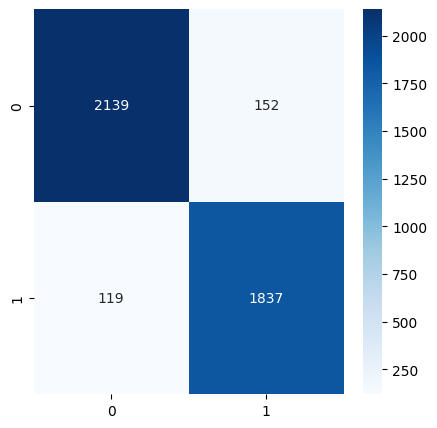

In [159]:
import seaborn as sb
import matplotlib.pyplot as plt
from math import sqrt
def model_diagnostic_stats(confusion_matrix):
    tp = confusion_matrix[1,1]
    tn = confusion_matrix[0,0]
    fp = confusion_matrix[0,1]
    fn = confusion_matrix[1,0]

    p = tp + fn
    n = fp + tn
    pp = tp + fp
    pn = fn + tn

    diagnostic_dict = {
    'recall' : tp/p,
    'false_neg_rate' : fn/p,
    'false_pos_rate' : fp/n,
    'true_neg_rate' : tn/n,
    'positive_liklihood_ratio' : (tp/p)/(fp/n),
    'neg_liklihood_rate' : (fn/p)/(tn/n),
    'precision' : tp/pp,
    'false_omission_rate' : fn/pn,
    'false_discovery_rate' : fp/pp,
    'neg_pred_value' : tn/pn,
    'markedness' : (tp/pp)+(tn/pn)-1,
    'diagnostic_odds_ration' : ((tp/p)/(fp/n))/( (fn/p)/(tn/n)),
    'informedness' : (tp/p)+(tn/n)-1,
    'prevalence_threshold' : (sqrt((tp/p)*(fp/n))-(fp/n))/((tp/p)-(fp/n)),
    'prevalence' : p/(p+n),
    'accuracy' : (tp+tn)/(p+n),
    'balanced_accuracy' : ((tp/p)+(tn/n))/2,
    'F1_score' : 2*tp/(2*tp+fp+fn),
    'fowlkes_mallows_index' : sqrt((tp/pp)*(tp/p)),
    'jaccard_index' : tp/(tp+fn+fp),
    }

    return diagnostic_dict
cm_matrix = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sb.heatmap(cm_matrix,annot=True,fmt='g',cmap="Blues")
stats = model_diagnostic_stats(cm_matrix)
print('Model Confusion Matrix Statistics:')
for key,value in stats.items():
    value_str = '%.4f' % value
    print("\n {}: {}".format(key,value_str))


In [154]:
results_df.to_csv('results_with_mlp.csv')

In [139]:
df2 = pd.read_csv('synthetic_data.csv')
y2 = df2['FLAG']

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
X2=df2[columns]

In [133]:
print("DataFrame shape:", X2.shape)
print("Column names:", X2.columns)
print(X2.head())


DataFrame shape: (14155, 12)
Column names: Index(['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance'],
      dtype='object')
   Avg min between sent tnx  Avg min between received tnx  \
0                   5151.68                      15159.08   
1                   1179.02                       1124.89   
2                    361.73                          0.00   
3                      0.00                          0.00   
4                  14280.60                       1479.86   

   Time Diff between first and last (Mins)  Unique Received From Addresses  \
0                                 71235.62                               1   
1                               

In [140]:
X2n=X2.values

scaler = MinMaxScaler()

for c in columns:
    X2[c] = X2[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scaling
# Fit the scaler to the data and transform X2
X2n = scaler.fit_transform(X2)


In [141]:
ensemble_predictions = model.predict(X2n)
accuracy = func(y2, ensemble_predictions)
print(f"Accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7161
